In [692]:
company_output = 'PETR4.SA'
end_date = '2024-11-15' 
start_date = '2024-06-01'
stock_var = 'Adj Close'
company_inputs = 'PETR4.SA'

seq_length = 30
batch_size = 30
h = 1

In [693]:
import mlflow
import mlflow.sklearn

scalerX_path = 'artifacts/transformers/scalerX'
scalery_path = 'artifacts/transformers/scalery'
model_path = 'artifacts/models_tf/best_models'

scalerX = mlflow.sklearn.load_model(scalerX_path)
scalery = mlflow.sklearn.load_model(scalery_path)
model = mlflow.sklearn.load_model(model_path)

In [694]:
from feature_engineering import get_finance_df, shift_drop_na_in_xy

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

df = get_finance_df(company_inputs, start_date, end_date, stock_var)

if (len(df) <= seq_length+h+1):
    raise Exception("Your dataset 'df' has less samples than the defined window size for data transformation, given by 'seq_length'")

X, y = shift_drop_na_in_xy(df, company_inputs, company_output, horizon_pred=h)

[*********************100%***********************]  1 of 1 completed


In [695]:
import numpy as np

# def make_predictions(X, y, seq_length, batch_size, scaler):

generator = TimeseriesGenerator(X, X, length=seq_length, batch_size=batch_size)

scaled_X = []
scaled_y = []
for k in range(len(generator)):
    X_temp, y_temp = generator[k]
    scaled_X.append(scalerX.transform(X_temp.reshape(-1,1)).reshape(len(X_temp),seq_length))
    scaled_y.append(scalery.transform(y_temp.reshape(-1,1)))
    
    # return generator, scaled_X, scaled_y

# def make_predictions(generator, scaled_X):
y_pred = []
y_valid = []
for k in range(len(generator)):
    y_pred_scaled = model.predict(scaled_X[k])
    y_pred.append(scalery.inverse_transform(y_pred_scaled.reshape(-1,1)))
    
    y_valid.append(scalery.inverse_transform(scaled_y[k].reshape(-1,1)))

y_pred = np.concatenate(y_pred, axis=0 )
y_valid = np.concatenate(y_valid, axis=0 )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


In [696]:
from sklearn.metrics import root_mean_squared_error, r2_score

# Calculate RMSE and R² score
rmse = root_mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print([ f"R2={r2}", f"RMSE={rmse}"])

['R2=0.15196095792823294', 'RMSE=0.9828935315310576']


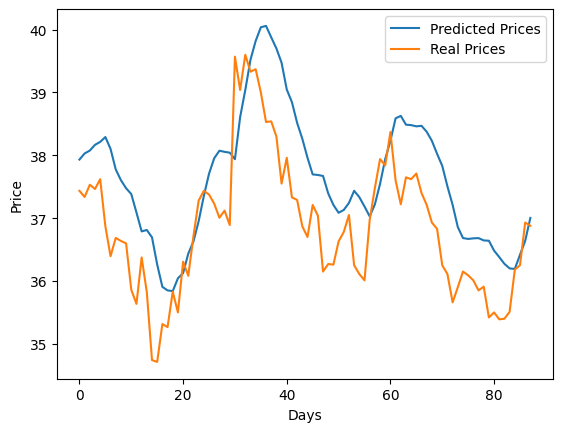

In [697]:
import matplotlib.pyplot as plt

# Plot the predicted prices\n"
plt.plot(y_pred, label="Predicted Prices")
plt.plot(y_valid, label="Real Prices")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()